In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, solve_ivp
from scipy.special import kn
import astropy.constants as ct

In [2]:
# constants

vev = 246 # GeV - Higgs VEV
m_h = 125 # GeV - Higgs mass
Gamma_h = 4.07e-3 # GeV - total Higgs decay width
M_W = 80.377 # GeV - W boson mass
M_Z = 91.1876 # GeV - Z boson mass

m_e = 0.511e-3 # GeV - electron mass
m_muon = 105.66e-3 # GeV - muon mass
m_tau = 1.77693 # GeV - tau mass
m_u = 2.16e-3 # GeV - up mass
m_d = 4.7e-3 # GeV - down mass
m_c = 1.273 # GeV - charm mass
m_s = 93.5e-3 # GeV - strange mass
m_t = 172.57 # GeV - top mass
m_b = 4.183 # GeV - bottom mass

M_V = [M_W, M_Z]
M_f = [m_e,m_muon,m_tau,m_u,m_d,m_c,m_s,m_t,m_b]
n_cs = [1,1,1,3,3,3,3,3,3]

c_V = [1,1/2]

g_V = 3
g_f = 2

C = 0.349 # no sé qué es esto

gstar = 106.75
MP = 2.4e18
T0 = 2.725*ct.k_B.value/ct.e.value*1e-9
gstars0 = 3.91
gstar0 = 3.38
s0 = 2*np.pi**2/45*gstars0*T0**3
gS = 1


In [3]:
def sigma_V(s,lambda_HS,M_S,m_V):
    A = g_V**-2*lambda_HS**2/(32*np.pi*s)
    B = ((s-4*M_S**2)/(s-4*m_V**2+0j))**0.5
    C = (s**2-4*s*m_V**2+12*m_V**4)/((s-m_h**2)**2+m_h**2*Gamma_h**2)
    return (A*B*C).real

def sigma_f(s,lambda_HS,M_S,m_f,n_c):
    A = (2*n_c)**-2*lambda_HS**2*n_c/(16*np.pi*s)
    B = ((s-4*m_f**2)*(s-4*M_S**2+0j))**0.5*m_f**2/((s-m_h**2)**2+m_h**2*Gamma_h**2)
    return (A*B).real

def sigma_h(s,lambda_HS,M_S):
    A = 1/(32*np.pi*s)*((s-4*M_S**2)/(s-4*m_h**2)+0j)**0.5
    B = lambda_HS + 3*m_h**2*lambda_HS/(s-m_h**2+1j*m_h*Gamma_h) - 4*vev**2*lambda_HS**2/(s-2*m_h**2)
    return (A*(B*B.conjugate())).real

def Gamma_hSS(lambda_HS,M_S):
    return (lambda_HS**2*vev**2/(32*np.pi*m_h)*(1-4*M_S**2/m_h**2+0j)**0.5).real


In [4]:
def thermal_average_cs(T,m_S,lambda_HS):
    gauge_bosons = 0
    fermions = 0
    for M in M_V:
        factor_V = 4*M/(T*kn(2,M/T)**2)
        integrand_V = lambda w: (np.tan(w)**2+1)*(np.tan(w)-1)*np.tan(w)**0.5*sigma_V(4*M**2*np.tan(w),lambda_HS,m_S,M)*kn(1,2*M/T*np.tan(w)**0.5)
        integral_V = quad(integrand_V,np.pi/4+1e-5,np.pi/2-1e-5)[0]
        gauge_bosons += factor_V*integral_V
    for M,n in zip(M_f,n_cs):
        factor_f = 4*M/(T*kn(2,M/T)**2)
        integrand_f = lambda w: (np.tan(w)**2+1)*(np.tan(w)-1)*np.tan(w)**0.5*sigma_f(4*M**2*np.tan(w),lambda_HS,m_S,M,n)*kn(1,2*M/T*np.tan(w)**0.5)
        integral_f = quad(integrand_f,np.pi/4+1e-5,np.pi/2-1e-5)[0]
        fermions += factor_f*integral_f
    
    integrand_h = lambda w: (np.tan(w)**2+1)*(np.tan(w)-1)*np.tan(w)**0.5*sigma_h(4*m_h**2*np.tan(w),lambda_HS,m_S)*kn(1,2*m_h/T*np.tan(w)**0.5)
    higgs = 4*m_h/(T*kn(2,m_h/T)**2)*quad(integrand_h,np.pi/4+1e-5,np.pi/2-1e-5)[0]

    return gauge_bosons + fermions + higgs

def Omegah2(m_S,lambda_HS):
    def Boltz_eq(x):
        H = (np.pi**2*gstar/90)**0.5*(m_S/x)**2/MP
        s = 2*np.pi**2/45*gstar*(m_S/x)**3
        def integrand(w):
            suma = 0
            for M in M_V:
                suma += sigma_V(4*m_S**2*np.tan(w),lambda_HS,m_S,M)
            for M,n in zip(M_f,n_cs):
                suma += sigma_f(4*m_S**2*np.tan(w),lambda_HS,m_S,M,n)
            suma += sigma_h(4*m_S**2*np.tan(w),lambda_HS,m_S)
            return (np.tan(w)**1.5-np.tan(w)**0.5)/np.cos(w)**2*suma*kn(1,2*x*np.tan(w)**0.5)
        integral = quad(integrand,np.pi/4,np.pi/2)[0]
        first_term = integral/(H*s)*(gS/(2*np.pi**2))**2*m_S**6/x**2
        second_term = C*m_h*m_S/(s*H*x**2)*Gamma_hSS(lambda_HS,m_S)*kn(1,m_h/m_S*x)
        return first_term + second_term
    Y = quad(Boltz_eq,1e-12,np.inf)[0]
    return s0*m_S*Y/(3*MP**2*(2.13e-42)**2)

thermal_average_cs = np.vectorize(thermal_average_cs)

In [5]:

thermal_average = lambda x,M_S,lambda_HS: thermal_average_cs(M_S/x,M_S,lambda_HS)

/tmp/ipykernel_7047/585542265.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  factor_f = 4*M/(T*kn(2,M/T)**2)
/tmp/ipykernel_7047/585542265.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  fermions += factor_f*integral_f
/tmp/ipykernel_7047/585542265.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  higgs = 4*m_h/(T*kn(2,m_h/T)**2)*quad(integrand_h,np.pi/4+1e-5,np.pi/2-1e-5)[0]
/tmp/ipykernel_7047/585542265.py:16: RuntimeWarning: invalid value encountered in scalar multiply
  higgs = 4*m_h/(T*kn(2,m_h/T)**2)*quad(integrand_h,np.pi/4+1e-5,np.pi/2-1e-5)[0]
/tmp/ipykernel_7047/585542265.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  factor_V = 4*M/(T*kn(2,M/T)**2)
/tmp/ipykernel_7047/585542265.py:8: RuntimeWarning: invalid value encountered in scalar multiply
  gauge_bosons += factor_V*integral_V


-15.0 7.381106550234064e-86
-14.696969696969697 1.2029364560667837e-84
-14.393939393939394 1.960486693270438e-83
-14.09090909090909 3.195104824620207e-82
-13.787878787878787 5.207224754625218e-81
-13.484848484848484 8.486478889907699e-80
-13.181818181818182 1.383084605381751e-78
-12.878787878787879 2.2540832899718695e-77
-12.575757575757576 3.6735941231360886e-76
-12.272727272727273 5.987043088238524e-75
-11.969696969696969 9.75738846996663e-74
-11.666666666666666 1.5902112002645917e-72
-11.363636363636363 2.5916480308543075e-71
-11.06060606060606 4.22374054132775e-70
-10.757575757575758 6.883644672449937e-69
-10.454545454545453 1.1218625650157385e-67
-10.151515151515152 1.8283564516640203e-66
-9.848484848484848 2.9797654530835164e-65
-9.545454545454545 4.8562752341365956e-64
-9.242424242424242 7.914518615981559e-63
-8.93939393939394 1.2898693320015878e-61
-8.636363636363637 2.1021656203807352e-60
-8.333333333333332 3.4260061743237295e-59
-8.030303030303031 5.583536422002894e-58
-7.727

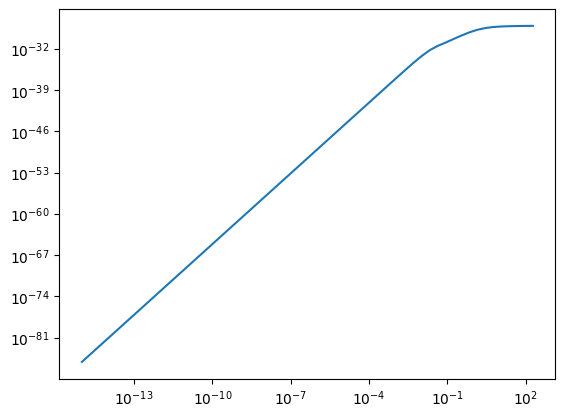

In [6]:
xs = np.logspace(-15,15,100)
sigs = thermal_average(xs,100,1e-11)
for i,j in zip(np.log10(xs),sigs):
    print(i,j)
plt.loglog(xs,sigs)

In [7]:
((np.pi/(2*10**2.575757575757578))**0.5*np.exp(-10**2.575757575757578))**-1

4.999233367275083e+164

In [8]:
## solo el canal W+W- -> SS
def thermal_average_W(x,m_S,lambda_HS):
    factor = 4*x
    integrand = lambda w: (np.tan(w)**1.5-np.tan(w)**0.5)/np.cos(w)**2*kn(1,2*x*np.tan(w)**0.5)*sigma_V(4*m_S**2*np.tan(w),lambda_HS,m_S,M_W)
    return factor*quad(integrand,np.pi/4,np.pi/2-1e-5)[0]

In [9]:
def Omegah2(m_S,lambda_HS):
    def Boltz_eq(x):
        H = (np.pi**2*gstar/90)**0.5*(m_S/x)**2/MP
        s = 2*np.pi**2/45*gstar*(m_S/x)**3
        first_term = thermal_average_W(x,m_S,lambda_HS)/(H*s*x)*((gS/(2*np.pi**2))*m_S**3/x)**2
        second_term = C*m_h*m_S/(s*H*x**2)*Gamma_hSS(lambda_HS,m_S)*kn(1,m_h/m_S*x)
        return first_term + second_term
    Y = quad(Boltz_eq,1e-12,1e10)[0]
    return s0*m_S*Y/(3*MP**2*(2.13e-42)**2)

In [10]:
Omegah2(1,1e-10)

0.0

In [11]:
# Sigma_WW en términos de w

def sigma_W(w,M_S,lambda_HS):
    A = g_V**-2*lambda_HS**2/(32*np.pi*4*M_W**2*np.tan(w))
    B = ((np.tan(w)-M_S**2/M_W**2)/(np.tan(w)-1+0j))**0.5
    C = (16*M_W**4*np.tan(w)**2-16*M_W**4*np.tan(w)+12*M_W**4)/((4*M_W**2*np.tan(w)-m_h**2)**2+m_h**2*Gamma_h**2)
    return (A*B*C).real

def sigma_Z(w,M_S,lambda_HS):
    A = g_V**-2*lambda_HS**2/(32*np.pi*4*M_S**2*np.tan(w))
    B = ((np.tan(w)-1+0j)/(np.tan(w)-M_Z**2/M_S**2))**0.5
    C = (16*M_S**4*np.tan(w)**2-16*M_S**2*M_Z**2+12*M_Z**4)/((4*M_S**2*np.tan(w)-m_h**2)**2+m_h**2*Gamma_h**2)
    return A*B*C

/home/santiago/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/santiago/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


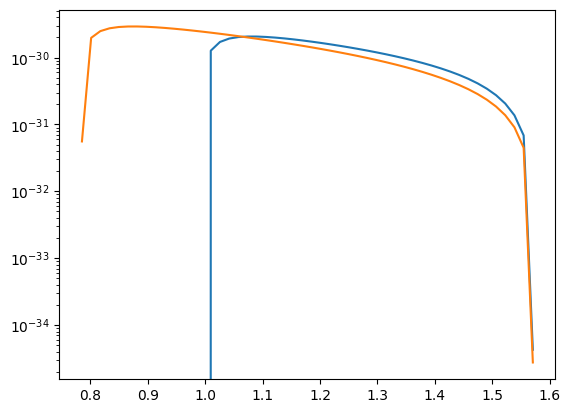

In [12]:
ws = np.linspace(np.pi/4+1e-5,np.pi/2-1e-5)
plt.semilogy(ws,sigma_V(4*M_W**2*np.tan(ws),1e-11,100,M_W))
plt.semilogy(ws,sigma_Z(ws,100,1e-11))

In [13]:
sigma_W(ws,1000,1e-11)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.27366785e-35])

In [14]:
def Omegah2(m_S,lambda_HS):
    def Boltz_eq(x):
        H = (np.pi**2*gstar/90)**0.5*(m_S/x)**2/MP
        s = 2*np.pi**2/45*gstar*(m_S/x)**3
        suma = 0
        for M in M_V:
            integrand_V = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma_V(4*M**2*np.tan(w),lambda_HS,m_S,M)*kn(1,2*M/m_S*np.tan(w)**0.5*x)).real
            integ_V = quad(integrand_V,np.pi/4+1e-5,np.pi/2-1e-5)[0]
            suma += (3**2/np.pi**4)*m_S*M**5/x*integ_V
        for M,n in zip(M_f,n_cs):
            integrand_f = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma_f(4*M**2*np.tan(w),lambda_HS,m_S,M,n)*kn(1,2*M/m_S*np.tan(w)**0.5*x)).real
            integ_f = quad(integrand_f,np.pi/4+1e-5,np.pi/2-1e-5)[0]
            suma += ((2*n)**2/np.pi**4)*m_S*M**5/x*integ_f
        integrand_h = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma_h(4*M**2*np.tan(w),lambda_HS,m_S)*kn(1,2*m_h/m_S*np.tan(w)**0.5*x)).real
        integ_h = quad(integrand_h,np.pi/4+1e-10,np.pi/2-1e-10)[0]
        suma += (1**2/np.pi**4)*m_S*m_h**5/x*integ_h

        return 1/(H*s*x)*(suma+C*m_h**2*m_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,m_S)*kn(1,m_h/m_S*x))

    Y = quad(Boltz_eq,0,np.inf)[0]
    return s0*m_S*Y/(3*MP**2*(1.45e-42)**2)*0.68**2

Omegah2 = np.vectorize(Omegah2)

In [22]:
(0.68/1.45e-42)**-1

2.1323529411764705e-42

In [15]:
mm = np.logspace(0,4)
ll = np.logspace(-13,-10,20)
MM, LL = np.meshgrid(mm,ll)

In [16]:
1.05e1*(ct.hbar.value*ct.c.value/ct.e.value*1e-9)**-3

1.3665637248024647e+48

In [17]:
Omegah2(1,1e-11)

array(0.0110515)

In [18]:
OO = Omegah2(MM,LL)

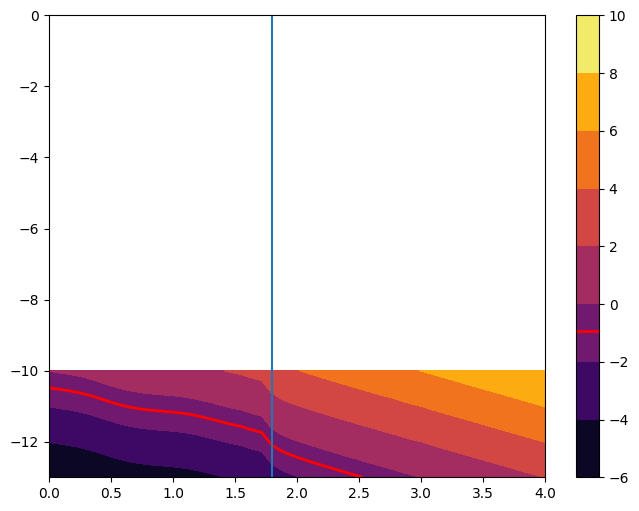

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(np.log10(MM),np.log10(LL),np.log10(OO),cmap='inferno',)
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='red',linestyles='solid',linewidths=2)
ax.vlines(np.log10(m_h/2),-13,0)
ax.set_ylim(-13,0)
cbar = fig.colorbar(CS)
cbar.add_lines(CSl)